In [1]:
import pandas as pd
import json
from pandas.io.json import json_normalize
import seaborn as sb
%pylab inline
import calendar
import datetime as dt

from pylab import rcParams
rcParams['figure.figsize'] = 20, 14

import fnmatch
import os
from tqdm import tqdm

Populating the interactive namespace from numpy and matplotlib


# Читаем и преобразовываем JSON

In [3]:
print('Обработка файлов JSON')

firstdata=True
rootDir='json_data'
files=os.listdir(rootDir)
pbar = tqdm(total=len(files))
datas=[]
for file in files:
    pbar.update(1)
    if fnmatch.fnmatch(file, '*.json'):
        with open(rootDir+'/'+file, encoding='utf8') as data_file:
            json_data = json.load(data_file)
            if firstdata:
                _columns=[val['Name']['#value'] for val in json_data['#value']['column']]#Вычленяем колонки
                firstdata=True
            datas.append(pd.DataFrame(data=json_data['#value']['row'], columns=_columns).applymap(lambda cell: cell['#value']))#читаем JSON и вычленяем значения
pbar.close()

print('Преобразуем в датафрейм...')

data=pd.concat(datas, axis=0, join='outer', ignore_index=True)

del json_data

            

Обработка файлов JSON


100%|██████████████████████████████████████| 1216/1216 [00:47<00:00, 28.61it/s]


Преобразуем в датафрейм...


# Преобразование характеристик

In [7]:
data['Дата']=pd.to_datetime(data['Дата'],format='%Y-%m-%d')#преобразуем дату

# Формируем новые характеристики

In [8]:
#параметры даты
data['Год']=data['Дата'].dt.year
data['Месяц']=data['Дата'].dt.month
data['Неделя']=data['Дата'].dt.week
data['День']=data['Дата'].dt.day
data['ДеньНедели']=data['Дата'].dt.weekday


#удаляем дату
data.drop('Дата', axis=1, inplace=True)

# 29 февраля: берем среднее за 28 и 29 февраля

In [9]:
condition29=(data['День'] > 28)&(data['Месяц']==2)
condition28=(data['День'] == 28)&(data['Месяц']==2)

def getCal(row):
    return dt.date(row['Год'], 2, 28).isocalendar()

#28 и 29 февраля  приравниваем к 28 февраля
data.ix[condition29,'День']=28
data.ix[condition28,'Неделя']=data.ix[condition28].apply(lambda row: getCal(row)[1], axis=1)
data.ix[condition28,'ДеньНедели']=data.ix[condition28].apply(lambda row: getCal(row)[2], axis=1)


#группируемые колонки
selectColumns=list(set(_columns)-set(['Дата','Количество'])|set(['Год','Месяц','День','Неделя','ДеньНедели']))

#среднее по 28 февраля
feb28=data[condition28].groupby(selectColumns)['Количество'].mean().reset_index()

#удаляем из оригинально датасета все 28 февраля
data.drop(data[condition28].index, inplace=True)

#добавляем среднее за 28 февраля
data=data.append(feb28)


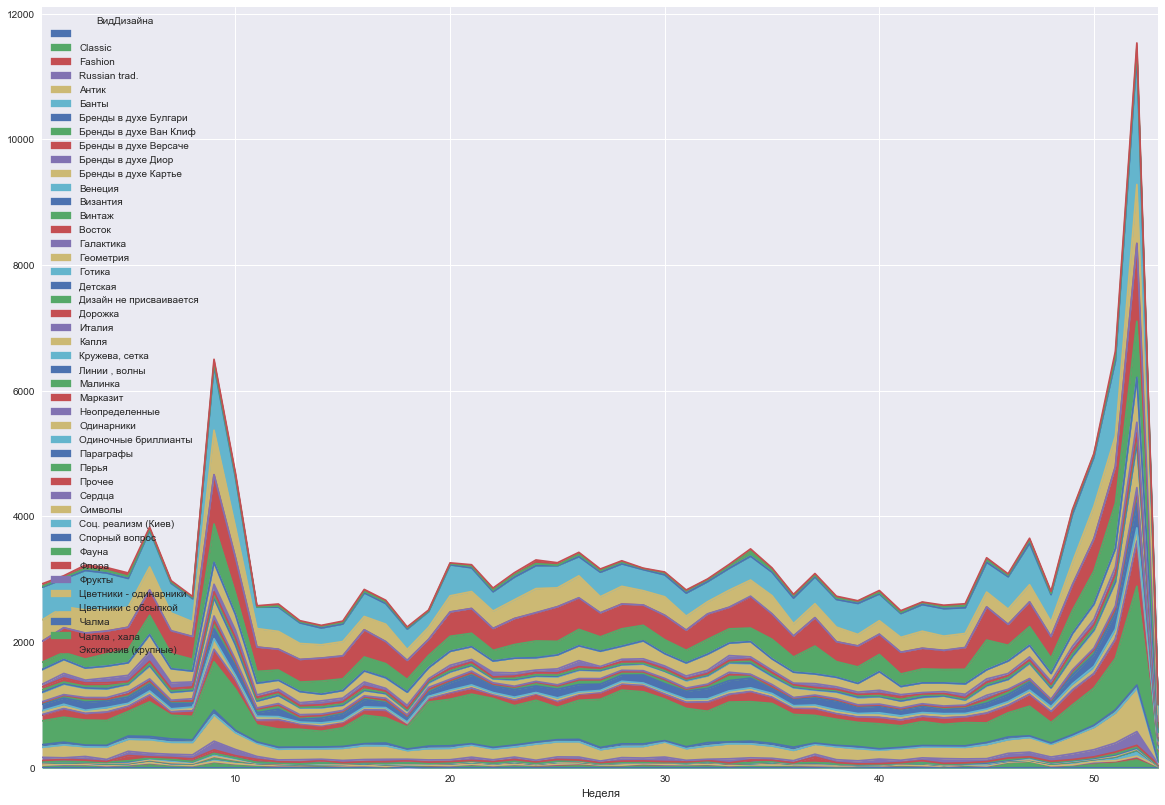

In [20]:
data[(data['Год']==2016)].pivot_table(index=['Неделя'], columns='ВидДизайна', values='Количество', aggfunc=sum,fill_value=0,dropna=False).plot(kind='area', legend=True,stacked=True)






In [10]:
data.head()

,АртикулБезКачества,Вес,ВидДизайна,ВидИзделия,Год,ГруппаТовара,День,ДеньНедели,Количество,Коллекция,...,ПодвидДизайна,ПодвидИзделия,Размер,СтильДизайна,Товар,ТоварСреднийВес,ТоварТип,ТоварЦеноваяГруппа,ЦветМеталла,ЦветПокрытия
0,С-ЗЖ-СЛ-5085-А,3.96,Флора,Серьги,2016,4 группа,12,0,1,Серебряный Век,...,,Серьги с англ. замком,0.0,Classic,Серьги С-ЗЖ-СЛ-5085-А,,Штучный,2100-3200,,
1,P50166,0.92,Дорожка,Подвеска,2016,3 группа,12,0,1,Бриллианты,...,,Прочие подвески,0.0,Fashion,Подвеска с бриллиантом P50166-31W,0.903,Штучный,9000-12000,Белое золото,
2,ЦП135УКА1П-А58,4.38,Дизайн не присваивается,Цепь,2016,1 группа,12,0,1,Цепи и браслеты,...,,Плетеные цепи,45.0,Classic,Цепь ЦП135УКА1П-А58,0.903,Весовой,12000-15000,Белое золото,
3,ПЛ-403К-32,0.80,Геометрия,Подвеска,2016,3 группа,12,0,1,Изумруды с бриллиантами,...,,Прочие подвески,0.0,Classic,Подвеска с бриллиантом и изумрудом ПЛ-403К-322...,0.827,Штучный,18000-23000,Красное золото,
4,К1322282,1.98,Дорожка,Кольцо,2016,2 группа,12,0,1,"С фианитом(с-ги,к-цо,подв,бр-т,колье)",...,,Прочие кольца,17.0,Classic,Кольцо К1322282,1.699,Весовой,3200-5000,Красное золото,


In [18]:
_columns

['Дата',
 'Товар',
 'АртикулБезКачества',
 'ВидИзделия',
 'ПодвидИзделия',
 'СтильДизайна',
 'ВидДизайна',
 'ПодвидДизайна',
 'ОсновнойКамень',
 'ГруппаТовара',
 'Коллекция',
 'МаркетинговаяЛинейка',
 'ЦветМеталла',
 'ЦветПокрытия',
 'ТоварСреднийВес',
 'ТоварТип',
 'ТоварЦеноваяГруппа',
 'Размер',
 'Количество',
 'Вес',
 'НеЗаказыватьУПоставщиков',
 'Контрагент']